# Investigate Berlin House Prices

## Table of Contents
<ul>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#gather">Gather</a></li>
        <li><a href="#assess">Assess</a></li>
        <li><a href="#clean">Clean</a></li>
    </ul>
</li>
<li><a href="#feature_engineering">Feature Engineering</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

<a id='introduction'></a>
## Introduction


Not so long ago, Berlin used to be a place associated with low living costs, attracting many people looking for high quality of life at cheap prices. Perhaps due to that popularity and other macro-economic shifts, those days are a thing of the past. Ask anyone living in Berlin at the moment and they will tell you how difficult it is to get a house rental contract, not only due to the scarcity of offers and plenty of demand for apartments, but also due to the soaring prices, even despite state regulation efforts. 

Having had to go recently through the pains of this process, I decided to use a data-driven approach to look for a new place to rent. For a period of a few months I collected some data on the market from the website [immobilienscout24](https://www.immobilienscout24.de/) for certain areas of Berlin (some areas were not included as I was not looking to live there). With the available data, I became interested in answering some questions to help me in my search, including:

- What are the most expensive areas?
- What is the most popular time to publish a new listing?
- How are listings that stay online less than 5 hours different to the rest?
- Does the number of rooms affect the time to rent a house?
- What characteristics of a house are more important to predict the price.
- What are the characteristics of a listing associated with being less time online?

The variables of this dataset are:

- `id` - id of listing
- `lat` - latitude of the listing
- `lon` - longitude of the listing
- `cold_price` - price of the listing before heating and upkeep costs
- `warm_price` - price of the listing after heating and upkeep costs
- `currency` - currency of the listing prices
- `short_listed` - if a given listing has short listed candidates
- `postcode_id` - post code of the listing
- `balcony` - if a listing has a balcony
- `builtin_kitchen` - if a listing has a built-in kitchen
- `created_date` - date the listing was created
- `modified_date` - date the listing was modified
- `published_date` - date the listing was published
- `energy_certificate` - if a listing has an energy certificate
- `has_new_flag` - if a listing is a new build or has been renovated recently.
- `living_space` - the living area in squared meters (m2)
- `new_home_builder` - if a listing has been built by new building company
- `number_rooms` - total number of rooms in listing
- `private_offer` - if a listing is pusblished by private owner
- `address` - address of the listing
- `link` - link to listing page
- `quarter` - district where listing is located
- `garden` - if a listing has a garden
- `listing_type` - listing size category
- `localhost_date` - date when listing data was saved into database
- `no_longer_available` - if listing is no longer available in website
- `no_longer_available_date` - date when listing was no longer available on the website

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re

from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<a id='wrangling'></a>
## Data Wrangling

<a id='gather'></a>
### Gather

Our dataset is available on a csv file, so all we have to do to import the dataset is by reading the file into memory.

In [2]:
df = pd.read_csv('berlin-houses.csv')
df.head()

,id,lat,lon,cold_price,currency,short_listed,postcode_id,balcony,builtin_kitchen,created_date,...,published_date,warm_price,address,link,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date
0,108076043,52.54692,13.39993,954.83,EUR,False,13355,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-13 21:28:29.524733,True,2019-06-19 20:59:47.343696
1,109645532,52.46982,13.43096,425.98,EUR,False,12051,True,False,2019-01-30 13:48:26.000000,...,2019-01-30 13:48:26.000000,630.98,"Schierker Straße 31, Neukölln (Neukölln), Berlin",https://www.immobilienscout24.de/expose/109645532,Neukölln (Neukölln),False,S,2019-04-13 21:28:30.204815,True,2019-06-21 06:36:13.552834
2,108077960,52.54727,13.39899,769.99,EUR,False,13355,True,True,2018-10-30 12:28:47.000000,...,2018-10-30 12:28:47.000000,952.47,"Lichtburgring 4, Wedding (Wedding), Berlin",https://www.immobilienscout24.de/expose/108077960,Wedding (Wedding),False,M,2019-04-13 21:28:29.522283,True,2019-06-19 20:59:47.345571
3,109503935,52.51210,13.46197,949.00,EUR,False,10245,False,False,2019-01-23 11:32:09.000000,...,2019-01-23 11:32:09.000000,1139.00,"Boxhagener Str. 98, Friedrichshain (Friedrichs...",https://www.immobilienscout24.de/expose/109503935,Friedrichshain (Friedrichshain),False,M,2019-04-13 21:28:29.538720,True,2019-06-19 20:59:47.352013
4,110143024,52.50508,13.38592,559.96,EUR,False,10963,True,False,2019-02-27 08:55:20.000000,...,2019-02-27 08:55:20.000000,735.51,"Anhalterstraße 11, Kreuzberg (Kreuzberg), Berlin",https://www.immobilienscout24.de/expose/110143024,Kreuzberg (Kreuzberg),False,S,2019-04-13 21:28:30.185993,True,2019-06-19 20:59:47.359163


<a id='assess'></a>
### Assess

In [3]:
df.columns

Index(['id', 'lat', 'lon', 'cold_price', 'currency', 'short_listed',
       'postcode_id', 'balcony', 'builtin_kitchen', 'created_date',
       'energy_certificate', 'has_new_flag', 'living_space',
       'new_home_builder', 'number_rooms', 'private_offer', 'modified_date',
       'published_date', 'warm_price', 'address', 'link', 'quarter', 'garden',
       'listing_type', 'localhost_date', 'no_longer_available',
       'no_longer_available_date'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1038 non-null   int64  
 1   lat                       1038 non-null   float64
 2   lon                       1038 non-null   float64
 3   cold_price                1038 non-null   float64
 4   currency                  1038 non-null   object 
 5   short_listed              1038 non-null   bool   
 6   postcode_id               1038 non-null   int64  
 7   balcony                   1038 non-null   bool   
 8   builtin_kitchen           1038 non-null   bool   
 9   created_date              1001 non-null   object 
 10  energy_certificate        1038 non-null   bool   
 11  has_new_flag              1038 non-null   bool   
 12  living_space              1018 non-null   float64
 13  new_home_builder          1038 non-null   bool   
 14  number_r

Looking at the above datatypes, we see that we have 4 different types: objects (string), ints, floats and booleans. On closer inspection, most datatypes seem to be correct except for the postcode, which should be of type object.

In [5]:
df.describe()

,id,lat,lon,cold_price,postcode_id,living_space,number_rooms,warm_price
count,1.038000e+03,1038.000000,1038.000000,1038.000000,1038.000000,1018.000000,1018.000000,1018.000000
mean,1.093818e+08,52.509401,13.423467,787.479653,10851.175337,63.034656,2.212181,966.603143
std,9.737607e+06,0.020471,0.030168,192.510034,831.004776,18.337413,0.477795,218.588139
min,3.140399e+07,52.467010,13.339400,0.000000,10099.000000,40.000000,2.000000,100.000000
25%,1.110968e+08,52.497450,13.400535,666.860000,10245.000000,53.500000,2.000000,817.250000
50%,1.122059e+08,52.508770,13.424590,800.000000,10435.000000,59.930000,2.000000,970.000000
75%,1.125261e+08,52.524010,13.447400,949.000000,10969.000000,69.175000,2.000000,1130.000000
max,1.127994e+08,52.549230,13.494310,1100.000000,13357.000000,456.000000,5.000000,1621.520000


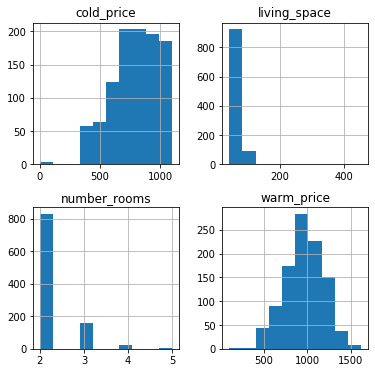

In [6]:
df[['cold_price', 'living_space', 'number_rooms', 'warm_price']].hist(figsize=(6, 6));

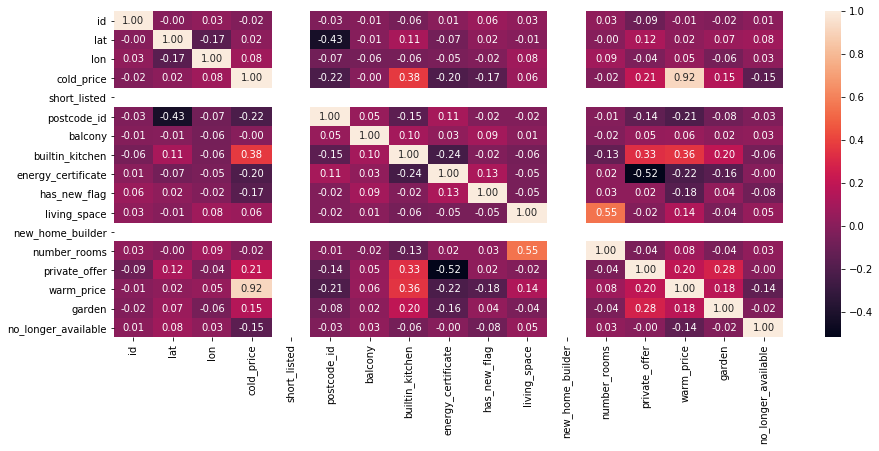

In [7]:
plt.figure(figsize=(15, 6))
sb.heatmap(df.corr(), annot=True, fmt=".2f");

In [8]:
(df.shape[0] - df.count()) / df.shape[0] * 100

id                           0.000000
lat                          0.000000
lon                          0.000000
cold_price                   0.000000
currency                     0.000000
short_listed                 0.000000
postcode_id                  0.000000
balcony                      0.000000
builtin_kitchen              0.000000
created_date                 3.564547
energy_certificate           0.000000
has_new_flag                 0.000000
living_space                 1.926782
new_home_builder             0.000000
number_rooms                 1.926782
private_offer                0.000000
modified_date                1.926782
published_date               3.564547
warm_price                   1.926782
address                      1.926782
link                         1.926782
quarter                      1.926782
garden                       0.000000
listing_type                 1.926782
localhost_date               0.000000
no_longer_available          0.000000
no_longer_av

In [9]:
df.currency.value_counts(dropna=False)

EUR    1038
Name: currency, dtype: int64

In [10]:
df.short_listed.value_counts(dropna=False)

False    1038
Name: short_listed, dtype: int64

In [11]:
df.postcode_id.value_counts(dropna=False)

10969    116
10245     87
10247     76
10243     55
10115     52
10249     49
10405     45
10437     43
10117     34
13355     34
10119     24
12059     24
12053     24
10963     24
12049     24
12051     21
12435     21
12045     21
12055     21
10407     21
10179     21
10435     19
10178     19
12043     18
10961     15
10785     15
10317     14
10967     13
10997     13
10965     12
10999     11
12047     10
10781      7
10823      6
10365      5
10777      4
10827      3
10439      3
10783      3
10787      2
10679      1
10707      1
10779      1
10367      1
10825      1
10248      1
13357      1
10099      1
10235      1
Name: postcode_id, dtype: int64

In [12]:
df.quarter.value_counts(dropna=False)

Friedrichshain (Friedrichshain)      267
Kreuzberg (Kreuzberg)                204
Neukölln (Neukölln)                  161
Mitte (Mitte)                        147
Prenzlauer Berg (Prenzlauer Berg)    134
Wedding (Wedding)                     29
Schöneberg (Schöneberg)               28
NaN                                   20
Lichtenberg (Lichtenberg)             17
Tiergarten (Tiergarten)               15
Treptow (Treptow)                     15
Plänterwald (Treptow)                  1
Name: quarter, dtype: int64

In [13]:
df.listing_type.value_counts(dropna=False)

S      758
M      228
L       27
NaN     20
XL       5
Name: listing_type, dtype: int64

In [14]:
df.number_rooms.value_counts(dropna=False)

2.0    831
3.0    160
4.0     25
NaN     20
5.0      2
Name: number_rooms, dtype: int64

In [15]:
df.new_home_builder.value_counts(dropna=False)

False    1038
Name: new_home_builder, dtype: int64

In [16]:
df.has_new_flag.value_counts(dropna=False)

True     905
False    133
Name: has_new_flag, dtype: int64

In [17]:
df.energy_certificate.value_counts(dropna=False)

True     768
False    270
Name: energy_certificate, dtype: int64

In [18]:
df.balcony.value_counts(dropna=False)

True     632
False    406
Name: balcony, dtype: int64

In [19]:
df.builtin_kitchen.value_counts(dropna=False)

False    578
True     460
Name: builtin_kitchen, dtype: int64

In [20]:
df.private_offer.value_counts(dropna=False)

False    833
True     205
Name: private_offer, dtype: int64

In [21]:
df.garden.value_counts(dropna=False)

False    975
True      63
Name: garden, dtype: int64

In [22]:
df[df.number_rooms.isnull()]

,id,lat,lon,cold_price,currency,short_listed,postcode_id,balcony,builtin_kitchen,created_date,...,published_date,warm_price,address,link,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date
0,108076043,52.54692,13.39993,954.83,EUR,False,13355,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-13 21:28:29.524733,True,2019-06-19 20:59:47.343696
133,87989317,52.49119,13.40320,682.00,EUR,False,10961,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.429389,True,2019-06-19 20:59:47.318677
135,111139962,52.50070,13.46418,750.00,EUR,False,10245,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.438342,True,2019-06-21 06:36:13.724755
154,111150063,52.54868,13.39900,924.00,EUR,False,13355,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.479311,True,2019-06-19 20:59:47.523904
159,111079921,52.47106,13.43346,655.49,EUR,False,12053,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-18 12:21:42.263275,True,2019-04-18 12:51:42.812337
181,111141306,52.49802,13.48991,888.00,EUR,False,10317,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.532199,True,2019-06-19 20:59:47.517946
182,111141541,52.48703,13.46637,799.00,EUR,False,12435,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.528689,True,2019-06-19 20:59:47.519911
183,111149077,52.53465,13.43516,670.00,EUR,False,10407,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.524850,True,2019-06-19 20:59:47.522001
361,112311101,52.48002,13.43807,445.00,EUR,False,12043,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-07-04 16:38:59.542529,True,2019-07-05 22:56:24.596261
451,112316783,52.49413,13.43607,700.00,EUR,False,10999,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-07-05 16:51:24.602817,True,2019-07-06 10:37:15.036043


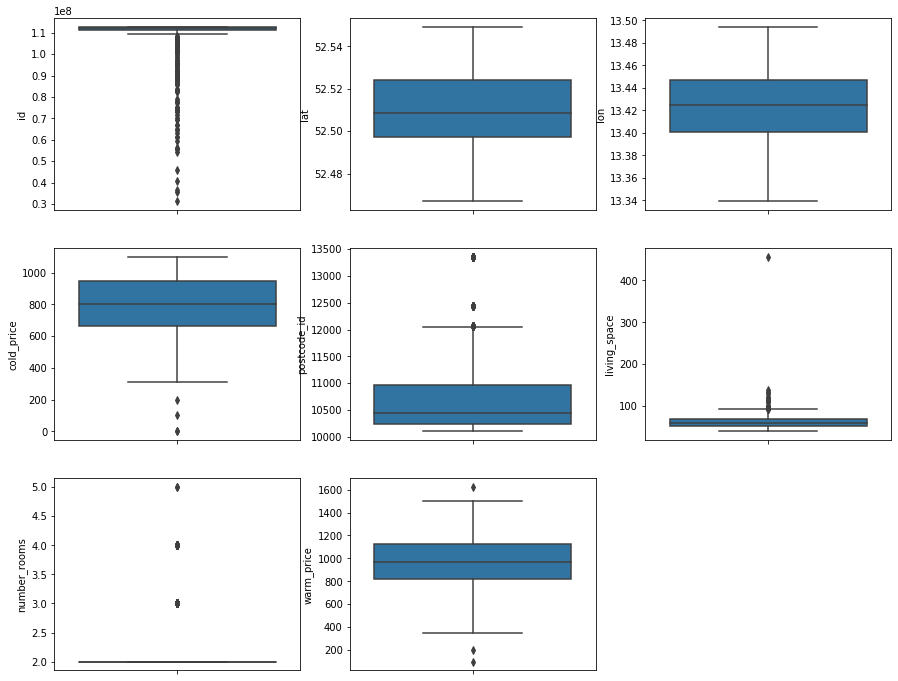

In [23]:
numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns

def plot_boxplot(data_frame, y, **kwargs):
    base_color = sb.color_palette()[0]
    plt.subplot(*kwargs['dimensions'])
    sb.boxplot(data=data_frame, y=y, color=base_color)
    
number_vars_row = 3
    
number_rows = round(len(numeric_vars) / number_vars_row)

fig_height = 4 * number_rows
fig_width = 5 * number_vars_row

plt.figure(figsize = [fig_width, fig_height])
for i, var in enumerate(numeric_vars):
    plot_boxplot(df, var, dimensions=(number_rows, number_vars_row, i + 1))

In [24]:
living_space_outlier = max(df.living_space)
df[df.living_space == living_space_outlier]

,id,lat,lon,cold_price,currency,short_listed,postcode_id,balcony,builtin_kitchen,created_date,...,published_date,warm_price,address,link,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date


In [25]:
warm_price_outlier_threshold = 300
df[df.warm_price < warm_price_outlier_threshold]

,id,lat,lon,cold_price,currency,short_listed,postcode_id,balcony,builtin_kitchen,created_date,...,published_date,warm_price,address,link,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date
152,110415016,52.51261,13.43144,200.0,EUR,False,10243,False,False,2019-03-30 20:10:17.000000,...,2019-03-30 20:10:17.000000,200.0,"ANDREASSTR. 10, Friedrichshain (Friedrichshain...",https://www.immobilienscout24.de/expose/110415016,Friedrichshain (Friedrichshain),False,S,2019-04-18 07:51:38.120686,True,2019-04-18 08:21:38.835512
728,112226322,52.50249,13.44740,100.0,EUR,False,10245,True,True,2019-06-28 20:21:00.000000,...,2019-06-28 20:21:00.000000,100.0,"Stralauer Allee 14, Friedrichshain (Friedrichs...",https://www.immobilienscout24.de/expose/112226322,Friedrichshain (Friedrichshain),False,S,2019-07-02 09:49:28.722442,True,2019-07-02 10:49:36.278302


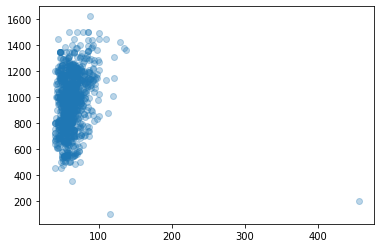

In [26]:
plt.scatter(data=df, x='living_space', y='warm_price', alpha=0.3);

### Quality

- `postcode_id` can be converted to `object` type.
- `listing_type` can be converted to categorical type.
- `number_rooms` can be converted to type `int`.
- `created_date`, `modified_date`, `published_date`, `localhost_date` and `no_longer_available_date` should be of type datetime.
- `currency`, `short_listed`, `new_home_builder` columns have only one value.
- `quarter` values have redundant information.
- There are 20 listings that seem to be missing most of the data in the columns.
- `address`, `lat` and `lon` columns have too sparse information for insights to come out of these columns. There are other columns enconding location information. `link` column can also be deleted as it does not add any information.
- There is an outlier in the column `living_space`.
- There are outliers in the `warm_price` column.

<a id='clean'></a>
### Clean

**- `postcode_id` can be converted to object type**<br>
**- `listing_type` can be converted to categorical type**<br>
**- `number_rooms` can be converted to type `int`.**<br>
**- `created_date`, `modified_date`, `published_date`, `localhost_date` and `no_longer_available_date` should be of type datetime**

##### Define
Convert `postcode_id` column to an object type.

##### Code

In [27]:
df.postcode_id = df.postcode_id.astype(str)

df.number_rooms = df.number_rooms.apply(lambda x: int(x) if not pd.isnull(x) else x)

datetime_columns = ['created_date', 'modified_date', 'published_date', 'localhost_date', 'no_longer_available_date']

for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])
    
cat_var = pd.CategoricalDtype(categories=['S', 'M', 'L', 'XL'], ordered=True)

df['listing_type'] = df['listing_type'].astype(cat_var)

##### Test

In [28]:
df[['postcode_id', 'number_rooms', 'listing_type', 'created_date', 'published_date', 'localhost_date', 'no_longer_available_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   postcode_id               1038 non-null   object        
 1   number_rooms              1018 non-null   float64       
 2   listing_type              1018 non-null   category      
 3   created_date              1001 non-null   datetime64[ns]
 4   published_date            1001 non-null   datetime64[ns]
 5   localhost_date            1038 non-null   datetime64[ns]
 6   no_longer_available_date  932 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](4), float64(1), object(1)
memory usage: 50.0+ KB


**- `currency`, `short_listed`, `new_home_builder` columns have only one value**

##### Define
As the columns `currency`, `short_listed`, `new_home_builder` add no information to the dataset, we should delete them.

##### Code

In [29]:
columns_to_delete = ['currency', 'short_listed', 'new_home_builder']

df.drop(columns=columns_to_delete, inplace=True)

##### Test

In [30]:
set(df.columns).intersection(set(columns_to_delete))

set()

**- `quarter` values have redundant information.**

##### Define
Delete the redundant information in parenthisisin each value of `quarter`.

##### Code

In [31]:
regex = r'(?<=[\(]).*?(?=[\)])'

def remove_extra(text):
    
    if not isinstance(text, str):
        return text
    
    matches = re.findall(regex, text)
    
    return matches[0]

df.quarter = df.quarter.apply(remove_extra)

##### Test

In [32]:
df.quarter.value_counts()

Friedrichshain     267
Kreuzberg          204
Neukölln           161
Mitte              147
Prenzlauer Berg    134
Wedding             29
Schöneberg          28
Lichtenberg         17
Treptow             16
Tiergarten          15
Name: quarter, dtype: int64

**- There are 20 listings that seem to be missing most of the data in the columns**

##### Define
These rows seem to be missing most of the data in the columns, and therefore it makes more sense to delete them than to input values to these rows. 

##### Code

In [33]:
df.drop(df[df.number_rooms.isnull()].index, axis=0, inplace=True)

##### Test

In [34]:
df[df.number_rooms.isnull()].index

Int64Index([], dtype='int64')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 1 to 1037
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1018 non-null   int64         
 1   lat                       1018 non-null   float64       
 2   lon                       1018 non-null   float64       
 3   cold_price                1018 non-null   float64       
 4   postcode_id               1018 non-null   object        
 5   balcony                   1018 non-null   bool          
 6   builtin_kitchen           1018 non-null   bool          
 7   created_date              1001 non-null   datetime64[ns]
 8   energy_certificate        1018 non-null   bool          
 9   has_new_flag              1018 non-null   bool          
 10  living_space              1018 non-null   float64       
 11  number_rooms              1018 non-null   float64       
 12  private_offer       

**- `address`, `lat` and `lon` columns have too sparse information for insights to come out of these columns. There are other columns enconding location information. `link` column can also be deleted as it does not add any information**

##### Define
Delete columns `address`, `lat`, `lon` and `link`.

##### Code

In [36]:
columns_to_delete = ['address', 'lat', 'lon', 'link']

df.drop(columns=columns_to_delete, inplace=True)

##### Test

In [37]:
set(df.columns).intersection(set(columns_to_delete))

set()

**- There is an outlier in the column `living_space`.**

##### Define
Further investigation into the row where the max value of `living_space` occurs (456m2) reveals that this is a row with some unusual data, as it is showing a `cold_price` and `warm_price` of 200 EUR, too low for such a high `living_space`. Therefore, we should delete this row.

##### Code

In [38]:
outlier = max(df.living_space)
df.drop(df[df.living_space == outlier].index, axis=0, inplace=True)

##### Test

In [39]:
df[df.living_space == outlier]

,id,cold_price,postcode_id,balcony,builtin_kitchen,created_date,energy_certificate,has_new_flag,living_space,number_rooms,private_offer,modified_date,published_date,warm_price,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date


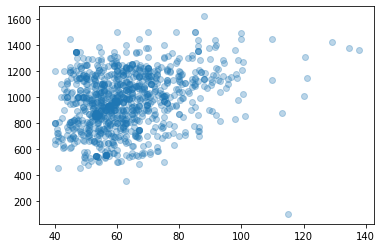

In [40]:
plt.scatter(data=df, x='living_space', y='warm_price', alpha=0.3);

**- There are outliers in the `warm_price` column.**

##### Define
Further investigation into the 2 rows whith unusally low values of `warm_price`, we conclude that probably these are typos when the person posted the listing online. Therefore, as the column `warm_price` will be the taerget variable of a prediction model, we should remove these outliers from the dataset. 

##### Code

In [41]:
warm_price_outlier_threshold = 300
df.drop(df[df.warm_price < warm_price_outlier_threshold].index, axis=0, inplace=True)

##### Test

In [42]:
df[df.warm_price < warm_price_outlier_threshold]

,id,cold_price,postcode_id,balcony,builtin_kitchen,created_date,energy_certificate,has_new_flag,living_space,number_rooms,private_offer,modified_date,published_date,warm_price,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date


<a id='feature_engineering'></a>
### Feature Engineering

**Create column to encode price difference between warm and cold price**

In [43]:
df['price_diff'] = (df['warm_price'] - df['cold_price']) / df['warm_price']

In [44]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff
count,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.00000,1016.000000
mean,1.093581e+08,788.521132,62.596732,2.208661,968.21063,0.187840
std,9.813651e+06,191.357164,13.488186,0.471622,215.76246,0.076917
min,3.140399e+07,0.000000,40.000000,2.000000,350.00000,0.000000
25%,1.110961e+08,666.395000,53.497500,2.000000,818.75000,0.142427
50%,1.122064e+08,800.000000,59.850000,2.000000,970.18500,0.178579
75%,1.125295e+08,949.415000,69.107500,2.000000,1130.75000,0.219800
max,1.127994e+08,1100.000000,137.840000,5.000000,1621.52000,1.000000


The rows where the `price_diff` is `1` should be investigated further.

In [45]:
df[df['price_diff'] == 1][['cold_price', 'warm_price', 'price_diff']]

,cold_price,warm_price,price_diff
798,0.0,350.0,1.0
809,0.0,1500.0,1.0


These rows happen when the cold price is `0`. As most likely a `cold_price` of `0` is a mistake, we should change the `price_diff` to 0 in these rows, making the warm price and cold price the same.

In [46]:
df.loc[df['cold_price'] == 0, 'price_diff'] = 0

In [47]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff
count,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.00000,1016.000000
mean,1.093581e+08,788.521132,62.596732,2.208661,968.21063,0.185872
std,9.813651e+06,191.357164,13.488186,0.471622,215.76246,0.068426
min,3.140399e+07,0.000000,40.000000,2.000000,350.00000,0.000000
25%,1.110961e+08,666.395000,53.497500,2.000000,818.75000,0.142053
50%,1.122064e+08,800.000000,59.850000,2.000000,970.18500,0.178467
75%,1.125295e+08,949.415000,69.107500,2.000000,1130.75000,0.219798
max,1.127994e+08,1100.000000,137.840000,5.000000,1621.52000,0.466667


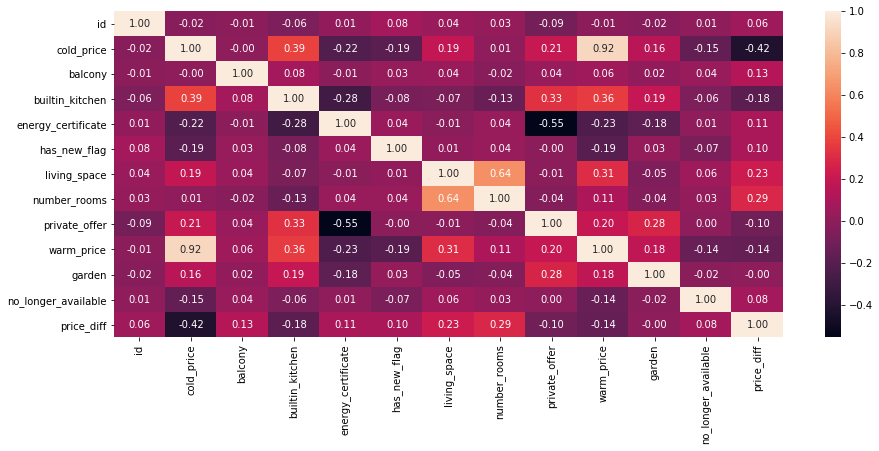

In [48]:
plt.figure(figsize=(15, 6))
sb.heatmap(df.corr(), annot=True, fmt=".2f");

**Create column to encode the amount of time an apartment was published online**

In [49]:
df['time_online'] = df.no_longer_available_date - df.published_date

In [50]:
df.head()

,id,cold_price,postcode_id,balcony,builtin_kitchen,created_date,energy_certificate,has_new_flag,living_space,number_rooms,...,published_date,warm_price,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date,price_diff,time_online
1,109645532,425.98,12051,True,False,2019-01-30 13:48:26,False,False,59.00,2.0,...,2019-01-30 13:48:26,630.98,Neukölln,False,S,2019-04-13 21:28:30.204815,True,2019-06-21 06:36:13.552834,0.324891,141 days 16:47:47.552834
2,108077960,769.99,13355,True,True,2018-10-30 12:28:47,True,False,51.98,2.0,...,2018-10-30 12:28:47,952.47,Wedding,False,M,2019-04-13 21:28:29.522283,True,2019-06-19 20:59:47.345571,0.191586,232 days 08:31:00.345571
3,109503935,949.00,10245,False,False,2019-01-23 11:32:09,True,False,80.00,2.0,...,2019-01-23 11:32:09,1139.00,Friedrichshain,False,M,2019-04-13 21:28:29.538720,True,2019-06-19 20:59:47.352013,0.166813,147 days 09:27:38.352013
4,110143024,559.96,10963,True,False,2019-02-27 08:55:20,True,False,64.63,2.0,...,2019-02-27 08:55:20,735.51,Kreuzberg,False,S,2019-04-13 21:28:30.185993,True,2019-06-19 20:59:47.359163,0.238678,112 days 12:04:27.359163
5,110364332,923.53,10245,True,False,2019-03-12 13:40:46,True,False,137.84,4.0,...,2019-03-12 13:40:46,1364.62,Friedrichshain,False,S,2019-04-13 21:28:30.119240,True,2019-06-19 20:59:47.366053,0.323233,99 days 07:19:01.366053


In [51]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff,time_online
count,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.00000,1016.000000,893
mean,1.093581e+08,788.521132,62.596732,2.208661,968.21063,0.185872,17 days 15:09:59.959237
std,9.813651e+06,191.357164,13.488186,0.471622,215.76246,0.068426,127 days 06:27:27.353486
min,3.140399e+07,0.000000,40.000000,2.000000,350.00000,0.000000,0 days 00:21:06.067150
25%,1.110961e+08,666.395000,53.497500,2.000000,818.75000,0.142053,0 days 07:53:37.529219
50%,1.122064e+08,800.000000,59.850000,2.000000,970.18500,0.178467,2 days 01:22:09.788923
75%,1.125295e+08,949.415000,69.107500,2.000000,1130.75000,0.219798,8 days 10:45:57.049104
max,1.127994e+08,1100.000000,137.840000,5.000000,1621.52000,0.466667,3433 days 19:08:42.481648


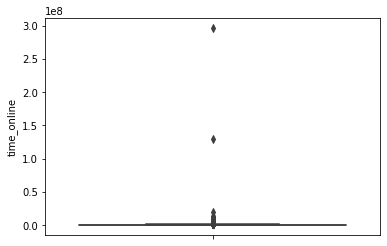

In [52]:
sb.boxplot(y=df['time_online'].astype('timedelta64[s]'))

Looking at the above table and boxplot, we see that we have rather extreme outliers in our new column. Investigating further these columns:  

In [53]:
df[df['time_online'] > np.timedelta64(300,'D')]

,id,cold_price,postcode_id,balcony,builtin_kitchen,created_date,energy_certificate,has_new_flag,living_space,number_rooms,...,published_date,warm_price,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date,price_diff,time_online
81,54267836,952.0,10961,False,False,2010-01-25 11:27:31,False,False,65.0,2.0,...,2010-01-25 11:27:31,1199.0,Kreuzberg,False,S,2019-04-13 21:28:30.234827,True,2019-06-21 06:36:13.481648,0.206005,3433 days 19:08:42.481648
742,82404802,1092.5,10965,True,True,2015-06-12 09:26:00,True,False,64.0,2.0,...,2015-06-12 09:26:00,1250.0,Kreuzberg,False,S,2019-07-16 12:54:43.041026,True,2019-07-23 10:44:50.328328,0.126000,1502 days 01:18:50.328328


Since these outliers are heavily skewing the distribution, we should replace these values by the average of the `time_online` column without these outliers.

In [54]:
cleaned_mean = df[df['time_online'] < np.timedelta64(300,'D')].mean()['time_online']

def clean_time_online(time_online):
    
    if pd.isnull(time_online):
        return time_online
    
    if time_online < np.timedelta64(300,'D'):
        return time_online
    else:
        cleaned_mean

df.time_online = df.time_online.apply(clean_time_online)

In [55]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff,time_online
count,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.00000,1016.000000,891
mean,1.093581e+08,788.521132,62.596732,2.208661,968.21063,0.185872,12 days 03:09:51.370133
std,9.813651e+06,191.357164,13.488186,0.471622,215.76246,0.068426,24 days 19:13:48.625170
min,3.140399e+07,0.000000,40.000000,2.000000,350.00000,0.000000,0 days 00:21:06.067150
25%,1.110961e+08,666.395000,53.497500,2.000000,818.75000,0.142053,0 days 07:53:33.836161
50%,1.122064e+08,800.000000,59.850000,2.000000,970.18500,0.178467,2 days 01:12:48.902699
75%,1.125295e+08,949.415000,69.107500,2.000000,1130.75000,0.219798,8 days 09:03:14.915160
max,1.127994e+08,1100.000000,137.840000,5.000000,1621.52000,0.466667,232 days 08:31:00.345571


In [56]:
numeric_vars = df.select_dtypes(include=['float64', 'int64', 'timedelta64']).columns
numeric_vars

Index(['id', 'cold_price', 'living_space', 'number_rooms', 'warm_price',
       'price_diff', 'time_online'],
      dtype='object')

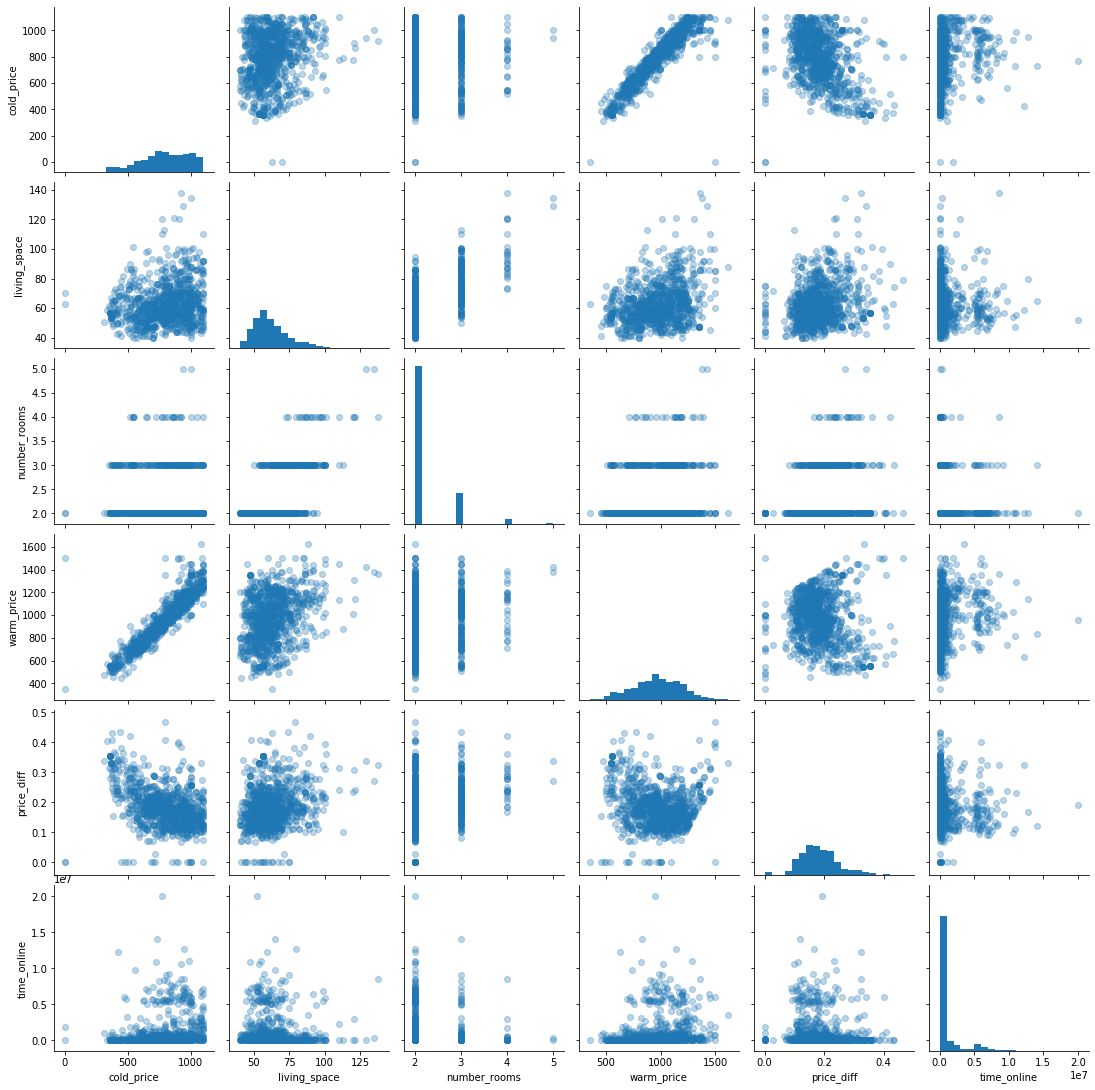

In [57]:
plot_df = df.copy()
plot_df = plot_df[numeric_vars]
plot_df['time_online'] = plot_df['time_online'].astype('timedelta64[s]')
plot_df.drop(columns='id', inplace=True)

g = sb.PairGrid(data=plot_df);
g.map_diag(plt.hist, bins=20);
g.map_offdiag(plt.scatter, alpha=0.3);

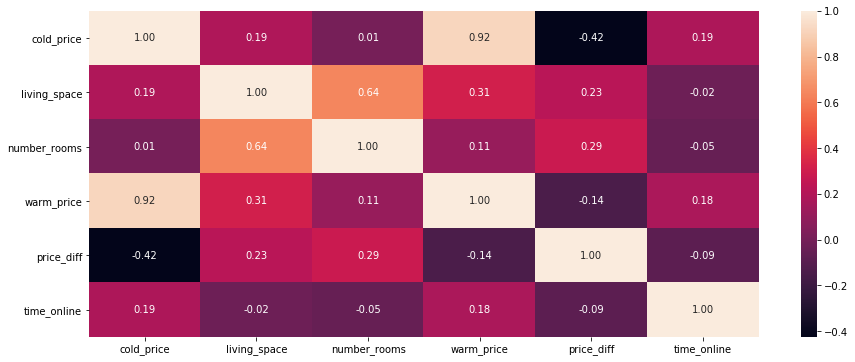

In [58]:
plt.figure(figsize=(15, 6))
sb.heatmap(plot_df.corr(), annot=True, fmt=".2f");

**Create column with publishing time of day**

In [59]:
df['time_of_day'] = df['published_date'].dt.time

In [60]:
df['time_of_day'] = df.published_date.dt.hour

labels = [f"{i}:00 - {j}:00" for i, j in zip(range(24), range(1, 24))]

df['time_of_day'] = pd.cut(df['time_of_day'], 23, right=False, labels=labels)

<a id='eda'></a>
## Exploratory Data Analysis

In this section we'll analyse the cleaned dataset and try to answer some of the questions we posed in the introduction. Below are some helper functions to postprocess tables and plots.

In [61]:
import six

def is_number(s):
    if isinstance(s, int):
        return False
    try:
        float(s)
        return True
    except ValueError:
        return False

def save_df(data, img_name, col_width=3.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
        
    data_values = [[round(item, 2) if is_number(item) else item for item in sub_list] for sub_list in data.values]

    mpl_table = ax.table(cellText=data_values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors) ])
            
    plt.savefig(img_name)
    return ax

In [62]:
base_color = sb.color_palette()[0]

def remove_borders(fig):
    
    axes = fig.axes[0]
    axes.spines["top"].set_visible(False)
    axes.spines["left"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.spines["bottom"].set_visible(False)

**What are the most expensive areas?**

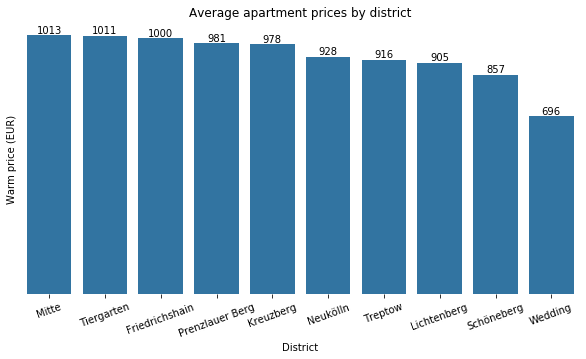

In [63]:
filtering_cond = df.groupby('quarter').count()['id'] > 1
sorted_quarter_prices = df.groupby('quarter').mean()[filtering_cond]['warm_price'].sort_values(ascending=False)

fig = plt.figure(figsize=(10, 5), frameon=False)
sb.barplot(sorted_quarter_prices.index, sorted_quarter_prices, color=base_color);
plt.xticks(rotation=20);
plt.yticks([])

plt.title('Average apartment prices by district');
plt.ylabel('Warm price (EUR)');
plt.xlabel('District');

remove_borders(fig)

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    
    price = sorted_quarter_prices[label.get_text()]
    pct_string = '{:0.0f}'.format(price)

    plt.text(loc, price + 10, pct_string, ha = 'center', color = '#000000')
    
plt.savefig('img/avg_prices_district.png')

In [64]:
def plot_hist_time(x, **kwargs):
    bins = np.arange(0, 2400 + 100, 100)
    if len(x) < 2:
        return
    plt.hist(x, bins=bins, color=base_color)

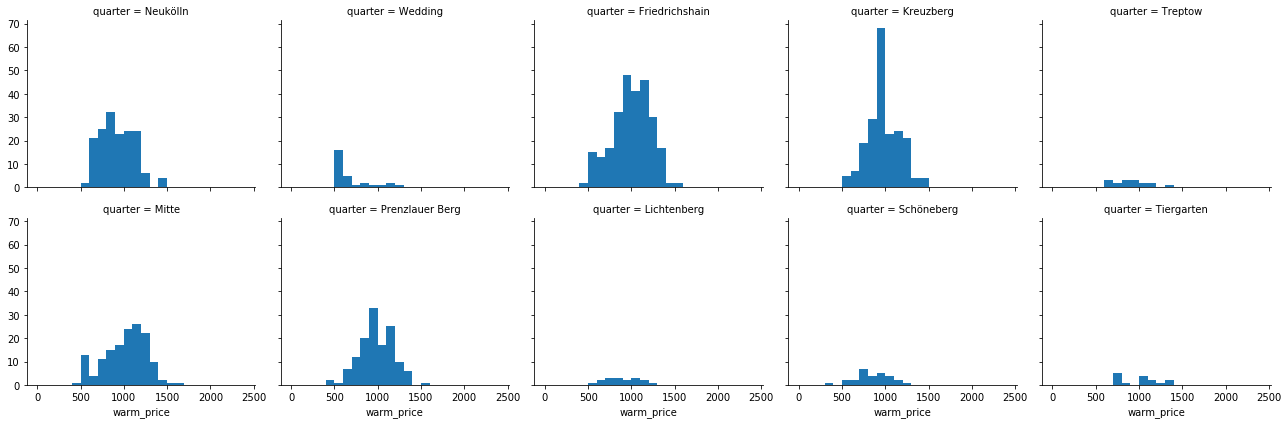

In [65]:
base_color = sb.color_palette()[0]

g = sb.FacetGrid(data=df, col='quarter', col_wrap=5, height=3, aspect=1.2)
g.map(plot_hist_time, 'warm_price');

**What is the most popular time to publish a new ad?**

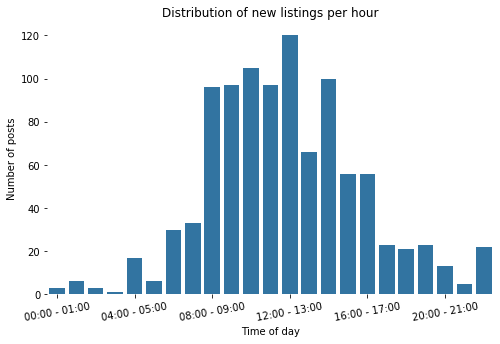

In [66]:
time_of_day_values = df.time_of_day.value_counts()

fig = plt.figure(figsize=(8, 5))
sb.barplot(time_of_day_values.index, time_of_day_values, color=base_color)

x_ticks_mapping = [
    (0, '00:00 - 01:00'), 
    (4, '04:00 - 05:00'), 
    (8, '08:00 - 09:00'), 
    (12, '12:00 - 13:00'), 
    (16, '16:00 - 17:00'), 
    (20, '20:00 - 21:00')
]

plt.xticks(*list(zip(*x_ticks_mapping)), rotation=10);
plt.xlabel('Time of day')
plt.ylabel('Number of posts')
plt.title('Distribution of new listings per hour')

remove_borders(fig)
plt.savefig('img/listings_per_hour.png')

According to the bar plot above, and somewhat expectedly, the most popular times to post new listings are in the morning, with a peak just before lunch time (12:00 - 13:00).

**How are listings that stay online less than 5 hours different to the rest?**

In [67]:
below_df = df[df['time_online'] < np.timedelta64(5, 'h')]
below_df = below_df.mean().to_frame()

above_df = df[df['time_online'] >= np.timedelta64(5, 'h')]
above_df = above_df.mean().to_frame()

In [68]:
comp_df = pd.merge(below_df, above_df, left_index=True, right_index=True)
comp_df.columns = ['below_5h', 'above_5h']
comp_df['diff_avgs'] = comp_df['above_5h'] - comp_df['below_5h']

comp_df.drop(['postcode_id', 'time_online', 'id'], axis=0, inplace=True)

numeric_rows = ['cold_price', 'price_diff', 'warm_price', 'living_space', 'number_rooms']

numeric_comp = comp_df.loc[numeric_rows, :]
boolean_comp = comp_df.loc[[row for row in comp_df.index if row not in numeric_rows], :]

In [69]:
numeric_comp.style.bar(subset=['diff_avgs'], align='mid', color=['#d65f5f', '#5fba7d'])

,below_5h,above_5h,diff_avgs
cold_price,672.484531,803.888340,131.403809
price_diff,0.203429,0.184435,-0.018993
warm_price,840.219740,987.007811,146.788072
living_space,66.052396,61.991559,-4.060836
number_rooms,2.359375,2.177396,-0.181979


In [70]:
boolean_comp.style.bar(subset=['diff_avgs'], align='mid', color=['#d65f5f', '#5fba7d'])

,below_5h,above_5h,diff_avgs
balcony,0.640625,0.623748,-0.016877
builtin_kitchen,0.333333,0.460658,0.127325
energy_certificate,0.848958,0.751073,-0.097885
has_new_flag,1.000000,0.849785,-0.150215
private_offer,0.093750,0.210300,0.116550
garden,0.031250,0.065808,0.034558
no_longer_available,1.000000,1.000000,0.000000


**Does the number of rooms affect the time to rent a house?**

In [71]:
df_copy = df.copy()
df_copy.time_online = df_copy.time_online.dt.total_seconds()
m = df_copy.groupby(['number_rooms']).mean()['time_online'].reset_index()
m.time_online = m.time_online.apply(lambda x: timedelta(seconds=x).days + timedelta(seconds=x).seconds / 3600 / 24)
m

,number_rooms,time_online
0,2.0,12.666007
1,3.0,10.125000
2,4.0,8.492014
3,5.0,2.743171


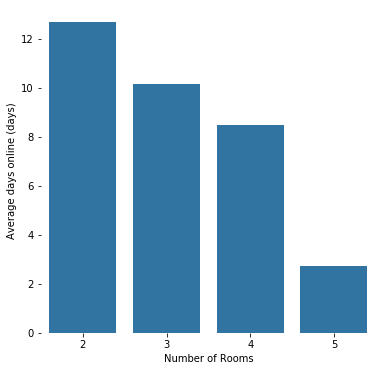

In [72]:
fig = plt.figure(figsize=(6, 6))
sb.barplot(data=m, x='number_rooms', y='time_online', color=base_color)
plt.xlabel('Number of Rooms');
plt.ylabel('Average days online (days)');
plt.yticks(rotation=0);

plt.xticks([0, 1, 2, 3], ['2', '3', '4', '5'])

remove_borders(fig)
plt.savefig('img/average_days_per_nr_rooms.png')

The average time a listing stays online becomes increasingly lower the more rooms a house has, meaning that houses that have more rooms are easier to rent. 

**What characteristics of a house are more important to predict the price.**

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 1 to 1037
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        1016 non-null   int64          
 1   cold_price                1016 non-null   float64        
 2   postcode_id               1016 non-null   object         
 3   balcony                   1016 non-null   bool           
 4   builtin_kitchen           1016 non-null   bool           
 5   created_date              999 non-null    datetime64[ns] 
 6   energy_certificate        1016 non-null   bool           
 7   has_new_flag              1016 non-null   bool           
 8   living_space              1016 non-null   float64        
 9   number_rooms              1016 non-null   float64        
 10  private_offer             1016 non-null   bool           
 11  modified_date             1016 non-null   datetime64[ns] 
 12  publis

In [74]:
df.select_dtypes(include=['bool']).columns

Index(['balcony', 'builtin_kitchen', 'energy_certificate', 'has_new_flag',
       'private_offer', 'garden', 'no_longer_available'],
      dtype='object')

In [75]:
df.select_dtypes(include=['float']).columns

Index(['cold_price', 'living_space', 'number_rooms', 'warm_price',
       'price_diff'],
      dtype='object')

In [76]:
df.select_dtypes(include=['object', 'category']).columns

Index(['postcode_id', 'quarter', 'listing_type', 'time_of_day'], dtype='object')

In [77]:
df.listing_type.value_counts()

S     756
M     228
L      27
XL      5
Name: listing_type, dtype: int64

In [78]:
df.time_of_day.value_counts()

12:00 - 13:00    120
10:00 - 11:00    105
14:00 - 15:00    100
11:00 - 12:00     97
9:00 - 10:00      97
8:00 - 9:00       96
13:00 - 14:00     66
16:00 - 17:00     56
15:00 - 16:00     56
7:00 - 8:00       33
6:00 - 7:00       30
19:00 - 20:00     23
17:00 - 18:00     23
22:00 - 23:00     22
18:00 - 19:00     21
4:00 - 5:00       17
20:00 - 21:00     13
5:00 - 6:00        6
1:00 - 2:00        6
21:00 - 22:00      5
2:00 - 3:00        3
0:00 - 1:00        3
3:00 - 4:00        1
Name: time_of_day, dtype: int64

In [79]:
df.quarter.value_counts()

Friedrichshain     265
Kreuzberg          204
Neukölln           161
Mitte              147
Prenzlauer Berg    134
Wedding             29
Schöneberg          28
Lichtenberg         17
Treptow             16
Tiergarten          15
Name: quarter, dtype: int64

In [80]:
model_columns = ['balcony', 'builtin_kitchen', 'energy_certificate', 'has_new_flag',
       'private_offer', 'garden', 'living_space', 'number_rooms', 'quarter', 'listing_type', 'warm_price']

In [81]:
df_model = df[model_columns]
df_model.head()

,balcony,builtin_kitchen,energy_certificate,has_new_flag,private_offer,garden,living_space,number_rooms,quarter,listing_type,warm_price
1,True,False,False,False,False,False,59.00,2.0,Neukölln,S,630.98
2,True,True,True,False,False,False,51.98,2.0,Wedding,M,952.47
3,False,False,True,False,False,False,80.00,2.0,Friedrichshain,M,1139.00
4,True,False,True,False,False,False,64.63,2.0,Kreuzberg,S,735.51
5,True,False,True,False,False,False,137.84,4.0,Friedrichshain,S,1364.62


In [82]:
def get_dummies(df, columns):
    
    for col in columns:
        df = pd.merge(df, pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True), left_index=True, right_index=True)
        
        df.drop(columns=[col], inplace=True)
        
    return df

In [83]:
df_model = get_dummies(df_model, ['quarter', 'listing_type'])
df_model.head()

,balcony,builtin_kitchen,energy_certificate,has_new_flag,private_offer,garden,living_space,number_rooms,warm_price,quarter_Kreuzberg,...,quarter_Mitte,quarter_Neukölln,quarter_Prenzlauer Berg,quarter_Schöneberg,quarter_Tiergarten,quarter_Treptow,quarter_Wedding,listing_type_M,listing_type_L,listing_type_XL
1,True,False,False,False,False,False,59.00,2.0,630.98,0,...,0,1,0,0,0,0,0,0,0,0
2,True,True,True,False,False,False,51.98,2.0,952.47,0,...,0,0,0,0,0,0,1,1,0,0
3,False,False,True,False,False,False,80.00,2.0,1139.00,0,...,0,0,0,0,0,0,0,1,0,0
4,True,False,True,False,False,False,64.63,2.0,735.51,1,...,0,0,0,0,0,0,0,0,0,0
5,True,False,True,False,False,False,137.84,4.0,1364.62,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 1 to 1037
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   balcony                  1016 non-null   bool   
 1   builtin_kitchen          1016 non-null   bool   
 2   energy_certificate       1016 non-null   bool   
 3   has_new_flag             1016 non-null   bool   
 4   private_offer            1016 non-null   bool   
 5   garden                   1016 non-null   bool   
 6   living_space             1016 non-null   float64
 7   number_rooms             1016 non-null   float64
 8   warm_price               1016 non-null   float64
 9   quarter_Kreuzberg        1016 non-null   uint8  
 10  quarter_Lichtenberg      1016 non-null   uint8  
 11  quarter_Mitte            1016 non-null   uint8  
 12  quarter_Neukölln         1016 non-null   uint8  
 13  quarter_Prenzlauer Berg  1016 non-null   uint8  
 14  quarter_Schöneberg      

In [85]:
target_var = 'warm_price'
features_vars = [col for col in df_model.columns if col != target_var]

In [86]:
X = df_model[features_vars]
y = df_model[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train);

In [88]:
reg.score(X_test, y_test)

0.3672548459288454

In [89]:
def get_coef_df(X_train, reg):
    
    coefs_df = pd.DataFrame()
    coefs_df['columns'] = [col.replace('_', ' ') for col in X_train.columns]
    coefs_df['coefs'] = reg.coef_
    coefs_df['abs_coefs'] = np.abs(reg.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coefs_df = get_coef_df(X_train, reg)
coefs_df.head(30)

,columns,coefs,abs_coefs
16,quarter Wedding,-260.716521,260.716521
13,quarter Schöneberg,-142.944289,142.944289
1,builtin kitchen,128.060776,128.060776
5,garden,117.372100,117.372100
19,listing type XL,106.959510,106.959510
3,has new flag,-106.186752,106.186752
15,quarter Treptow,-79.567779,79.567779
17,listing type M,74.952693,74.952693
9,quarter Lichtenberg,-74.208674,74.208674
11,quarter Neukölln,-45.836550,45.836550


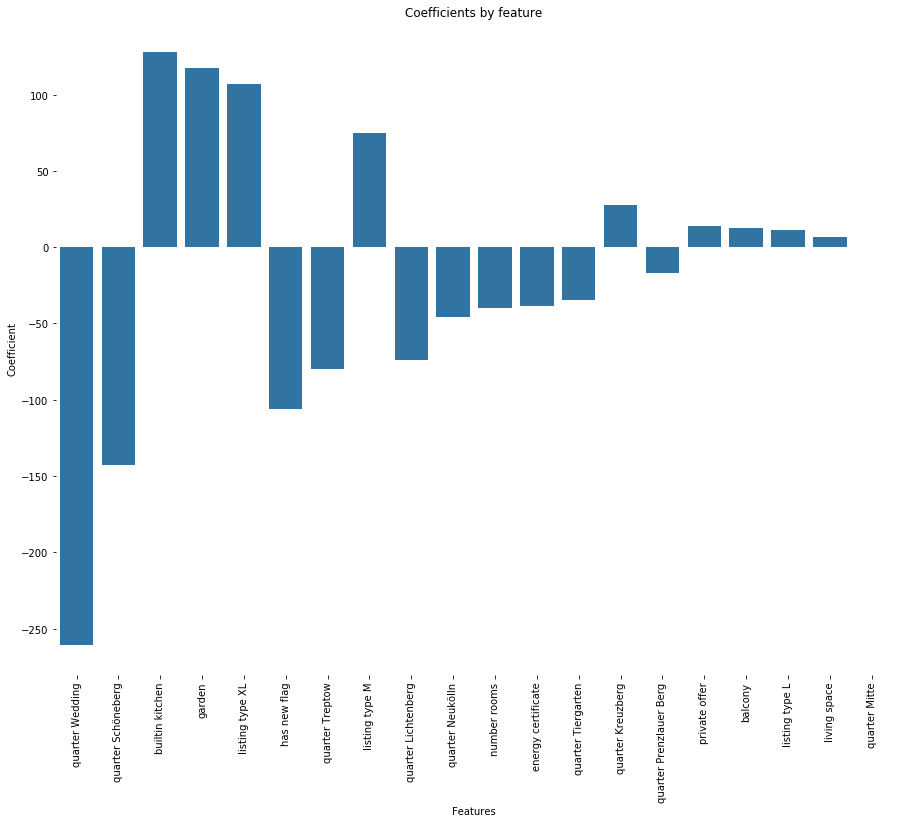

In [90]:
fig = plt.figure(figsize=(15, 12))
sb.barplot(data=coefs_df, x='columns', y='coefs', color=base_color);
remove_borders(fig)
plt.xticks(rotation=90);
plt.title('Coefficients by feature')
plt.xlabel('Features')
plt.ylabel('Coefficient')

plt.savefig('img/coefs_barplot.png');

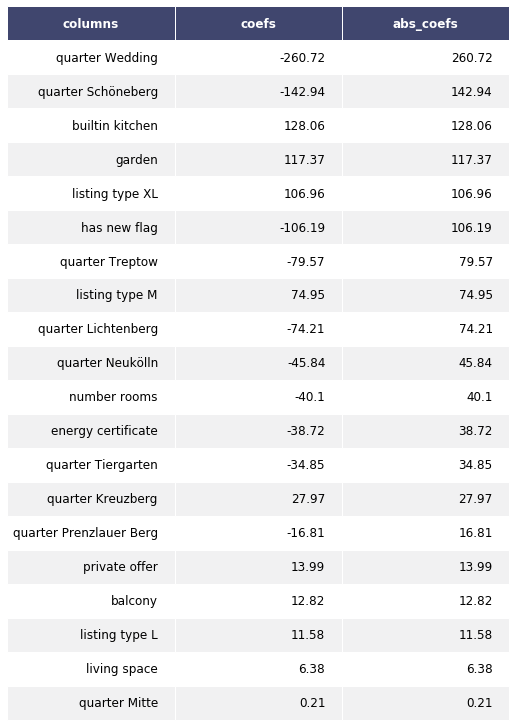

In [91]:
save_df(coefs_df, 'img/coefs_df');

**What are the characteristics of a listing associated with being less time online?**

In [92]:
model_2_columns = ['balcony', 'builtin_kitchen', 'energy_certificate', 'has_new_flag', 'private_offer', 
                   'garden', 'living_space', 'number_rooms', 'warm_price', 'price_diff', 'quarter', 
                  'time_online']

In [93]:
df_model_2 = df[model_2_columns].copy()
df_model_2.head()

,balcony,builtin_kitchen,energy_certificate,has_new_flag,private_offer,garden,living_space,number_rooms,warm_price,price_diff,quarter,time_online
1,True,False,False,False,False,False,59.00,2.0,630.98,0.324891,Neukölln,141 days 16:47:47.552834
2,True,True,True,False,False,False,51.98,2.0,952.47,0.191586,Wedding,232 days 08:31:00.345571
3,False,False,True,False,False,False,80.00,2.0,1139.00,0.166813,Friedrichshain,147 days 09:27:38.352013
4,True,False,True,False,False,False,64.63,2.0,735.51,0.238678,Kreuzberg,112 days 12:04:27.359163
5,True,False,True,False,False,False,137.84,4.0,1364.62,0.323233,Friedrichshain,99 days 07:19:01.366053


In [94]:
df_model_2 = get_dummies(df_model_2, ['quarter'])
df_model_2.head()

,balcony,builtin_kitchen,energy_certificate,has_new_flag,private_offer,garden,living_space,number_rooms,warm_price,price_diff,time_online,quarter_Kreuzberg,quarter_Lichtenberg,quarter_Mitte,quarter_Neukölln,quarter_Prenzlauer Berg,quarter_Schöneberg,quarter_Tiergarten,quarter_Treptow,quarter_Wedding
1,True,False,False,False,False,False,59.00,2.0,630.98,0.324891,141 days 16:47:47.552834,0,0,0,1,0,0,0,0,0
2,True,True,True,False,False,False,51.98,2.0,952.47,0.191586,232 days 08:31:00.345571,0,0,0,0,0,0,0,0,1
3,False,False,True,False,False,False,80.00,2.0,1139.00,0.166813,147 days 09:27:38.352013,0,0,0,0,0,0,0,0,0
4,True,False,True,False,False,False,64.63,2.0,735.51,0.238678,112 days 12:04:27.359163,1,0,0,0,0,0,0,0,0
5,True,False,True,False,False,False,137.84,4.0,1364.62,0.323233,99 days 07:19:01.366053,0,0,0,0,0,0,0,0,0


In [95]:
df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 1 to 1037
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   balcony                  1016 non-null   bool           
 1   builtin_kitchen          1016 non-null   bool           
 2   energy_certificate       1016 non-null   bool           
 3   has_new_flag             1016 non-null   bool           
 4   private_offer            1016 non-null   bool           
 5   garden                   1016 non-null   bool           
 6   living_space             1016 non-null   float64        
 7   number_rooms             1016 non-null   float64        
 8   warm_price               1016 non-null   float64        
 9   price_diff               1016 non-null   float64        
 10  time_online              891 non-null    timedelta64[ns]
 11  quarter_Kreuzberg        1016 non-null   uint8          
 12  quarter_Lichtenberg 

In [96]:
df_model_2.dropna(subset=['time_online'], inplace=True)

In [97]:
df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 1037
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   balcony                  891 non-null    bool           
 1   builtin_kitchen          891 non-null    bool           
 2   energy_certificate       891 non-null    bool           
 3   has_new_flag             891 non-null    bool           
 4   private_offer            891 non-null    bool           
 5   garden                   891 non-null    bool           
 6   living_space             891 non-null    float64        
 7   number_rooms             891 non-null    float64        
 8   warm_price               891 non-null    float64        
 9   price_diff               891 non-null    float64        
 10  time_online              891 non-null    timedelta64[ns]
 11  quarter_Kreuzberg        891 non-null    uint8          
 12  quarter_Lichtenberg  

In [98]:
df_model_2.time_online = df_model_2.time_online.dt.total_seconds()

In [99]:
target_var = 'time_online'
features_vars = [col for col in df_model_2.columns if col != target_var]

In [100]:
X = df_model_2[features_vars]
y = df_model_2[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train);

In [102]:
coefs_df_2 = get_coef_df(X_train, reg)

In [103]:
reg.score(X_test, y_test)

0.22353755611066994

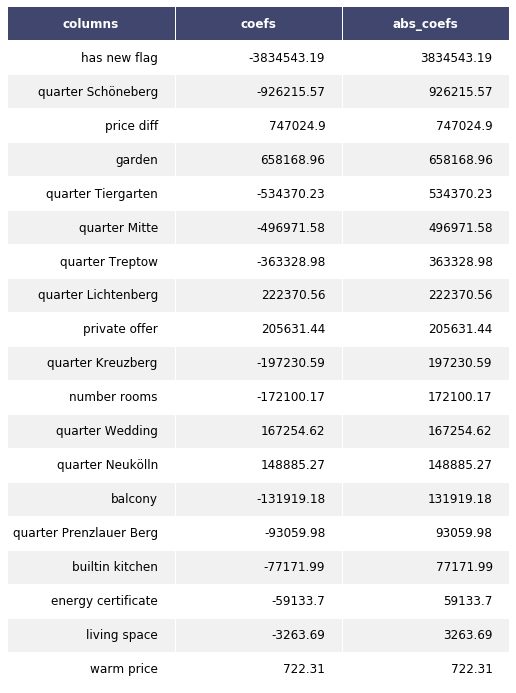

In [104]:
save_df(coefs_df_2, 'img/coefs_df_2.png');

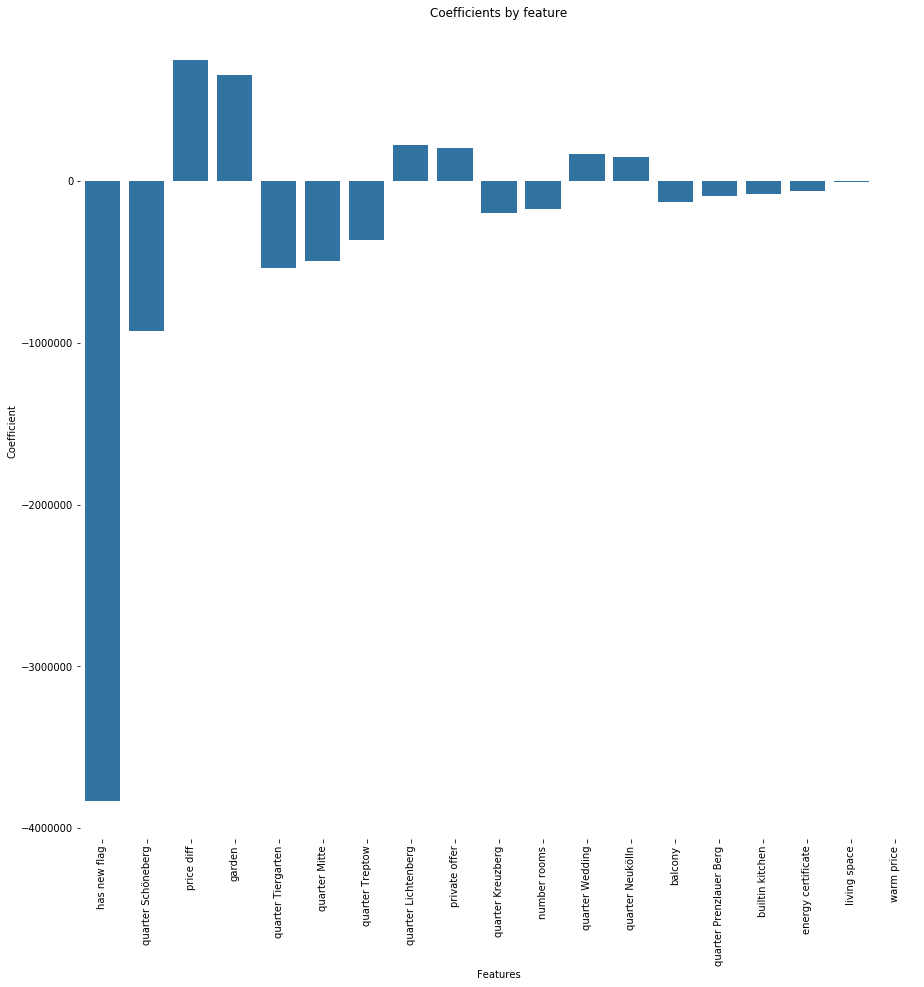

In [105]:
fig = plt.figure(figsize=(15, 15))
sb.barplot(data=coefs_df_2, x='columns', y='coefs', color=base_color);
remove_borders(fig)
plt.xticks(rotation=90);

plt.title('Coefficients by feature')
plt.xlabel('Features')
plt.ylabel('Coefficient')

plt.savefig('img/coefs_barplot_2.png');